# Library

In [1]:
# General Data Handling and Processing Libraries
import os
import shutil
import numpy as np
import pandas as pd
import cv2
from PIL import Image, ImageOps, Image as PILImage  # Image manipulation from PIL
from IPython.display import Image as IPImage  # For displaying images in Jupyter notebook

# PyTorch and Related Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset, WeightedRandomSampler
from torchvision import transforms

# Machine Learning and Data Handling
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from graphviz import Digraph
from torchsummary import summary
from torchviz import make_dot
from IPython.display import Image  # For model visualization

# Utility Libraries
import re
import math
from collections import defaultdict

# Load Dataset 

In [2]:
class HandwrittenDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.labels = self.data.iloc[:, 0].values  
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_array = self.data.iloc[idx, 1:].values.astype(np.uint8)  
        img_array = img_array.reshape(28, 28)  
        img = PILImage.fromarray(img_array)  
        
        if self.transform:
            img = self.transform(img)  
            
        label = self.labels[idx]
        return img, label

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((128, 128)),
    transforms.RandomApply([transforms.RandomInvert()], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

csv_file = 'A_Z Handwritten Data.csv'
full_dataset = HandwrittenDataset(csv_file, transform=train_transform)

labels = full_dataset.labels

train_idx, temp_idx = train_test_split(
    np.arange(len(labels)), 
    test_size=0.2, 
    stratify=labels, 
    random_state=42
)

val_idx, test_idx = train_test_split(
    temp_idx, 
    test_size=0.5, 
    stratify=labels[temp_idx], 
    random_state=42
)

train_subset = Subset(full_dataset, train_idx)
val_subset = Subset(full_dataset, val_idx)
test_subset = Subset(full_dataset, test_idx)

val_subset.dataset.transform = test_transform
test_subset.dataset.transform = test_transform

print(f"Train subset length: {len(train_subset)}")
print(f"Val subset length: {len(val_subset)}")
print(f"Test subset length: {len(test_subset)}")

train_labels = full_dataset.labels[train_idx]
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(train_labels), 
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Menghitung bobot untuk setiap sampel di train_subset
class_sample_count = np.array([
    len(np.where(train_labels == t)[0]) for t in np.unique(train_labels)
])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in train_labels])
samples_weight = torch.from_numpy(samples_weight).double()

sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight))

train_loader = DataLoader(train_subset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

class_weights = compute_class_weight('balanced', classes=np.unique(full_dataset.labels), y=full_dataset.labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

Using cuda
Train subset length: 297960
Val subset length: 37245
Test subset length: 37245


# Model

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
    
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        
        return out

class CNN(nn.Module):
    def __init__(self, num_classes=26):
        super(CNN, self).__init__()
        self.in_channels = 64
        
        self.conv = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, 
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)  # 64
        x = self.layer2(x)  # 128
        x = self.layer3(x)  # 256
        x = self.layer4(x)  # 512
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

In [5]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# x = torch.randn(1, 1, 128, 128).to(device)  
# y = model(x)

# make_dot(y, params=dict(model.named_parameters())).render("model_architecture", format="png")
# Image(filename="model_architecture.png")

In [6]:
from IPython.display import Image

train_losses = []
val_losses = []
test_losses = []
train_accuracies = [] 
val_accuracies = []
test_accuracies = []

num_epochs = 10
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0  
    total_train = 0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train 
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    test_loss = 0.0
    correct_test = 0
    total_test = 0
    test_labels = []
    test_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
            test_labels.extend(labels.cpu().numpy())
            test_predictions.extend(predicted.cpu().numpy())
    
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, ' 
          f'Val Loss: {avg_val_loss:.4f}, '
          f'Val Accuracy: {val_accuracy:.2f}%, '
          f'Test Loss: {avg_test_loss:.4f}, '
          f'Test Accuracy: {test_accuracy:.2f}%')

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

model.load_state_dict(torch.load('best_model.pth'))
model.eval()

correct = 0
total = 0
test_labels = []
test_predictions = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        test_labels.extend(labels.cpu().numpy())
        test_predictions.extend(predicted.cpu().numpy())

test_accuracy = 100 * correct / total
print(f'Test Accuracy (Final): {test_accuracy:.2f}%')

Epoch [1/10], Train Loss: 0.0982, Train Accuracy: 94.71%, Val Loss: 0.0458, Val Accuracy: 98.39%, Test Loss: 0.0453, Test Accuracy: 98.49%
Epoch [2/10], Train Loss: 0.0247, Train Accuracy: 98.47%, Val Loss: 0.0414, Val Accuracy: 98.19%, Test Loss: 0.0400, Test Accuracy: 98.44%
Epoch [3/10], Train Loss: 0.0155, Train Accuracy: 98.98%, Val Loss: 0.0325, Val Accuracy: 98.64%, Test Loss: 0.0346, Test Accuracy: 98.67%
Epoch [4/10], Train Loss: 0.0102, Train Accuracy: 99.29%, Val Loss: 0.0278, Val Accuracy: 98.74%, Test Loss: 0.0286, Test Accuracy: 98.88%
Epoch [5/10], Train Loss: 0.0085, Train Accuracy: 99.35%, Val Loss: 0.0223, Val Accuracy: 99.03%, Test Loss: 0.0267, Test Accuracy: 99.08%
Epoch [6/10], Train Loss: 0.0060, Train Accuracy: 99.54%, Val Loss: 0.0206, Val Accuracy: 99.18%, Test Loss: 0.0239, Test Accuracy: 99.24%
Epoch [7/10], Train Loss: 0.0054, Train Accuracy: 99.56%, Val Loss: 0.0193, Val Accuracy: 99.34%, Test Loss: 0.0224, Test Accuracy: 99.33%
Epoch [8/10], Train Loss: 0

C:\Users\ASUS\AppData\Local\Temp\ipykernel_25956\904784092.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Accuracy (Final): 99.37%


# Evaluation

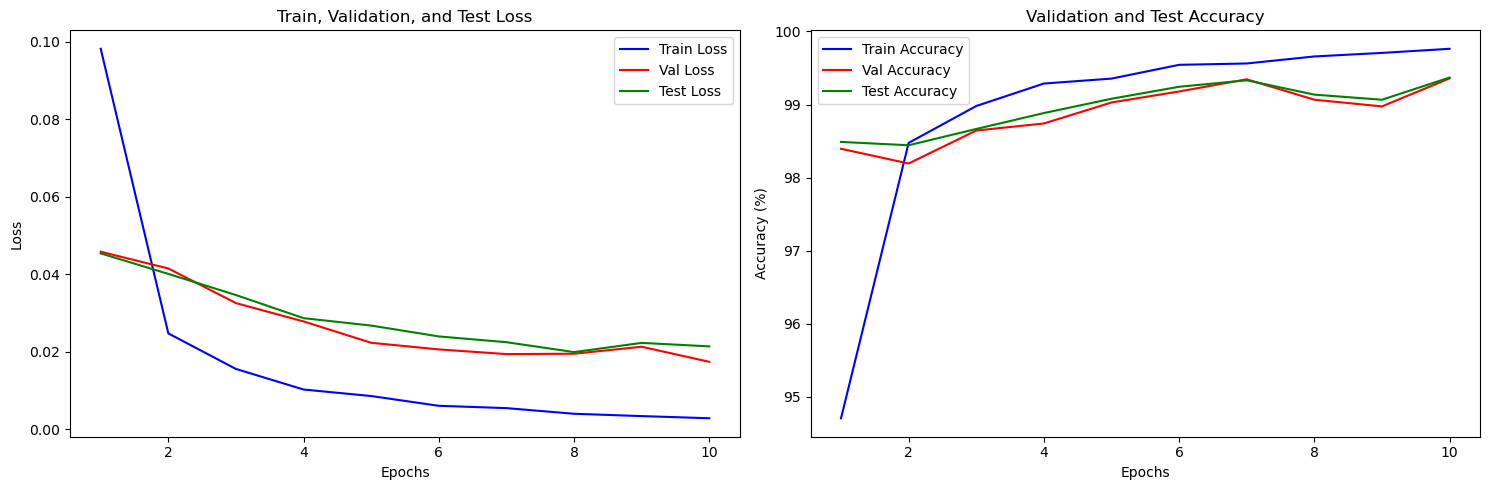

In [7]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, val_losses, label='Val Loss', color='red')
plt.plot(epochs, test_losses, label='Test Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train, Validation, and Test Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
plt.plot(epochs, val_accuracies, label='Val Accuracy', color='red')
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation and Test Accuracy')

plt.tight_layout()
plt.show()

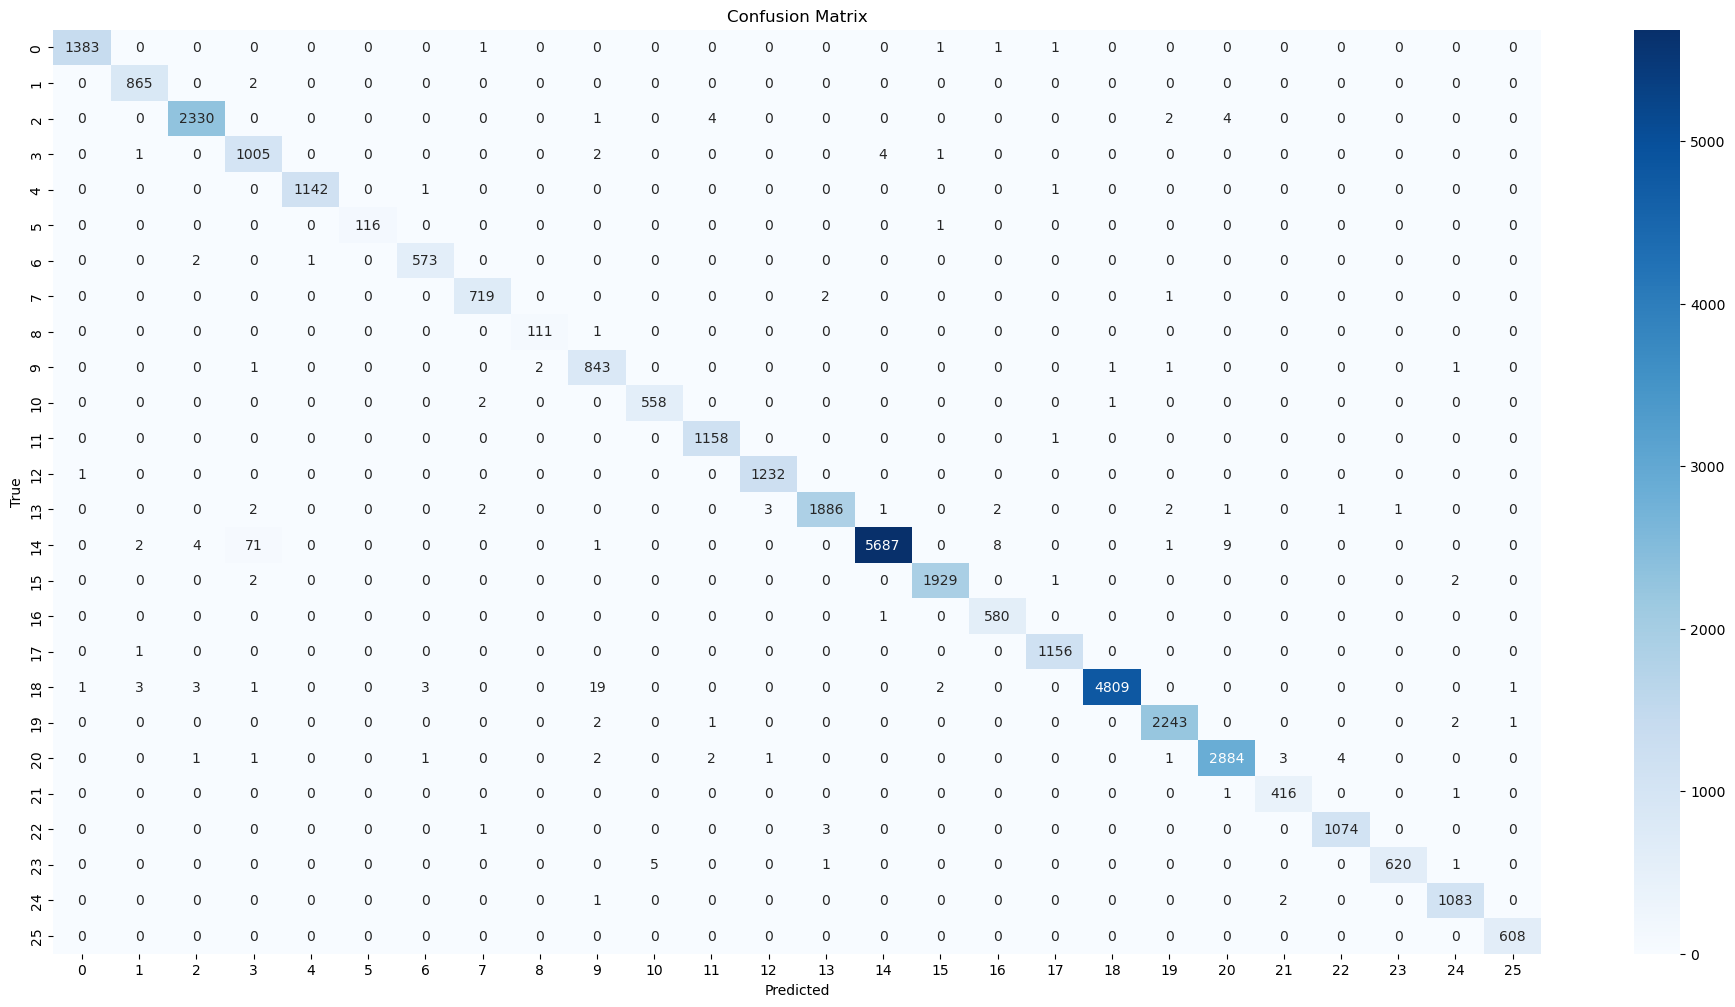

In [8]:
cm = confusion_matrix(test_labels, test_predictions)

plt.figure(figsize=(24, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(full_dataset.labels), yticklabels=np.unique(full_dataset.labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save Model

In [9]:
model_save_path = 'model.pth'
torch.save(model.state_dict(), model_save_path)
model.eval()

CNN(
  (conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

---

# Input 

**Split into chars**

In [10]:
def visualize(images, titles, figsize=(10, 5)):
    plt.figure(figsize=figsize)
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.show()

In [11]:
def segment_characters(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    visualize([gray, binary], ["Grayscale", "Binary"])

    num_labels, _, stats, _ = cv2.connectedComponentsWithStats(binary, connectivity=8)

    bounding_boxes = [
        (x, y, w, h) for i, (x, y, w, h, area) in enumerate(stats) if i != 0 and not (w < 20 and h < 20)
    ]

    line_threshold = 30
    bounding_boxes.sort(key=lambda box: box[1])
    lines = []
    for box in bounding_boxes:
        placed = False
        for line in lines:
            if abs(line[-1][1] - box[1]) < line_threshold:
                line.append(box)
                placed = True
                break
        if not placed:
            lines.append([box])

    for line in lines:
        line.sort(key=lambda box: box[0])

    chars_dir = 'chars'
    if os.path.exists(chars_dir):
        shutil.rmtree(chars_dir)
    os.makedirs(chars_dir)

    characters = []
    space_threshold = 30

    for line_idx, line in enumerate(lines):
        word_idx = 0
        previous_x = None
        for char_idx, (x, y, w, h) in enumerate(line):
            if previous_x is not None and (x - previous_x) > space_threshold:
                word_idx += 1
            previous_x = x + w

            char_image = binary[y:y + h, x:x + w]
            characters.append(char_image)
            char_filename = f'chars/char_{line_idx}_{word_idx}_{char_idx}.png'
            cv2.imwrite(char_filename, 255 - char_image)

    return characters

**process images on chars folder**

In [12]:
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'([0-9]+)', s)]

class PadToSquareTransform:
    def __init__(self, fill=0):
        self.fill = fill

    def __call__(self, img):
        return pad_to_square(img, fill=self.fill)

def pad_to_square(img, padding_mode='constant', fill='white', pad_ratio=0.15):
    width, height = img.size
    max_side = max(width, height)
    
    padding_left = (max_side - width) // 2
    padding_right = max_side - width - padding_left
    padding_top = (max_side - height) // 2
    padding_bottom = max_side - height - padding_top

    img_padded = ImageOps.expand(
        img, 
        border=(padding_left, padding_top, padding_right, padding_bottom), 
        fill=fill
    )
    
    additional_padding = int(max_side * pad_ratio)
    img_padded = ImageOps.expand(
        img_padded, 
        border=(additional_padding, additional_padding, additional_padding, additional_padding), 
        fill=fill
    )
    
    return img_padded


def predict_image(model, image_path, processed_images_folder="processed_images"):
    image = PILImage.open(image_path).convert('L') 
    image = ImageOps.invert(image) 
    img_array = np.array(image)
    kernel = np.ones((2, 2), np.uint8)
    img_array = cv2.dilate(img_array, kernel, iterations=1)
    image = PILImage.fromarray(img_array)  
   
    transform = transforms.Compose([
        PadToSquareTransform(fill=0),
        transforms.Grayscale(num_output_channels=1),  
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    processed_image = transform(image).unsqueeze(0).to(device)
    
    if not os.path.exists(processed_images_folder):
        os.makedirs(processed_images_folder)
    processed_image_pil = transforms.ToPILImage()(processed_image.squeeze(0).cpu())
    processed_image_pil.save(os.path.join(processed_images_folder, os.path.basename(image_path)))

    model.eval()
    with torch.no_grad():
        output = model(processed_image)
        _, predicted = torch.max(output, 1)
        return chr(65 + predicted.item())

def predict_folder(model, folder_path, processed_images_folder="processed_images"):
    results = []
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    for filename in image_files:
        image_path = os.path.join(folder_path, filename)
        prediction = predict_image(model, image_path, processed_images_folder)
        results.append((filename, prediction))
    return results

def display_sorted_predictions(predictions, processed_images_folder="processed_images"):
    sorted_predictions = sorted(predictions, key=lambda x: natural_sort_key(x[0]))
    lines = defaultdict(lambda: defaultdict(list))
    
    for filename, pred in sorted_predictions:
        match = re.match(r'char_(\d+)_(\d+)_(\d+)\.png', filename)
        if match:
            line_idx = int(match.group(1))
            word_idx = int(match.group(2))
            char_idx = int(match.group(3))
            lines[line_idx][word_idx].append((char_idx, filename, pred))

    result = ''
    for line_idx in sorted(lines.keys()):
        for word_idx in sorted(lines[line_idx].keys()):
            chars = sorted(lines[line_idx][word_idx], key=lambda x: x[0])
            word_text = ''.join(pred for _, _, pred in chars)
            result += word_text + ' '  
        result = result.strip() + '\n'  
    print(result)
    
    return result

**Process all test images**

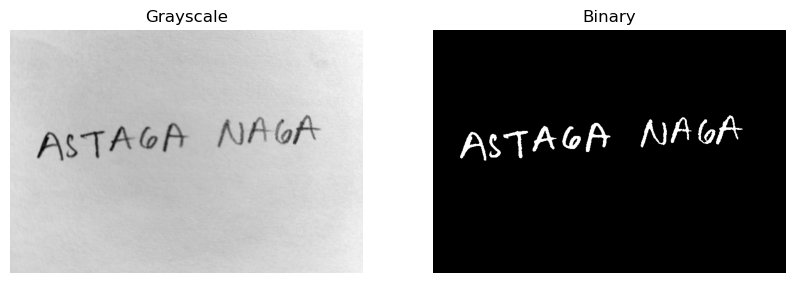

ASTAGA NAGA



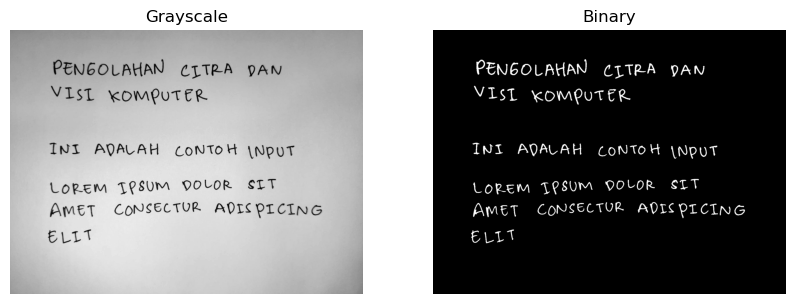

PENGOLAHAN CITRA DAN
VISI KOMPUTEMR
INI ADALAH CONTOH LNPUT
LOREM IPSUM DOLOR SIT
AMET CONSECTUR ADISPICING
ELIT



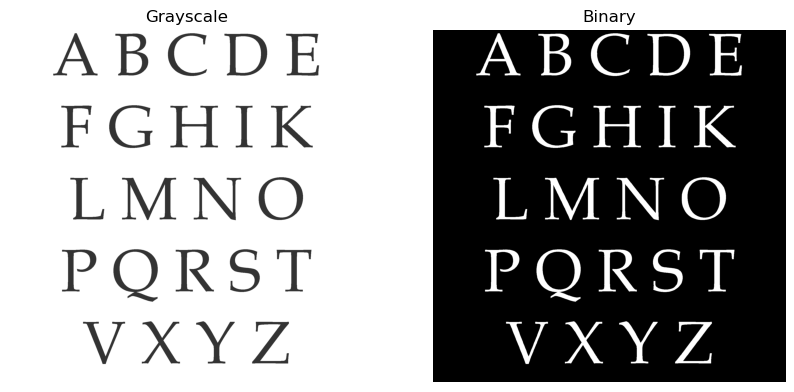

A B C D B
E G H I K
L M N O
P Q R S I
V X V L



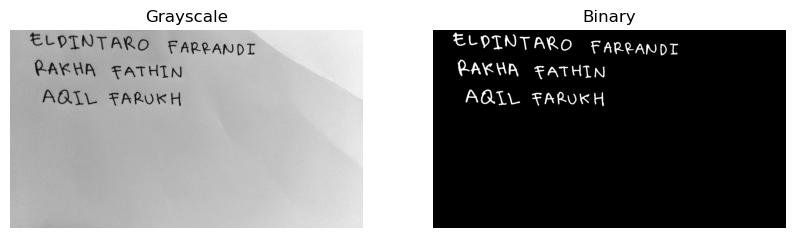

ELDINTARO FARRANDI
RAKHA FATHIN
AQIL FARUKH



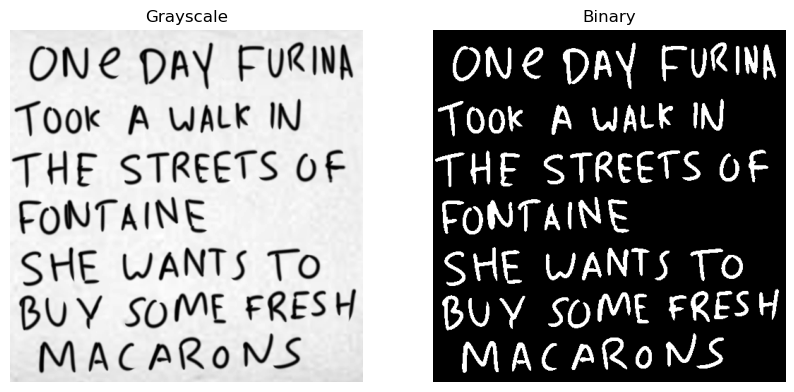

ONRDAY FURLNA
TOOK AWALKYN
THE STREETSUF
FONTALNE
SHE WANTSTO
BUY SUMEFRESH
MACARONS



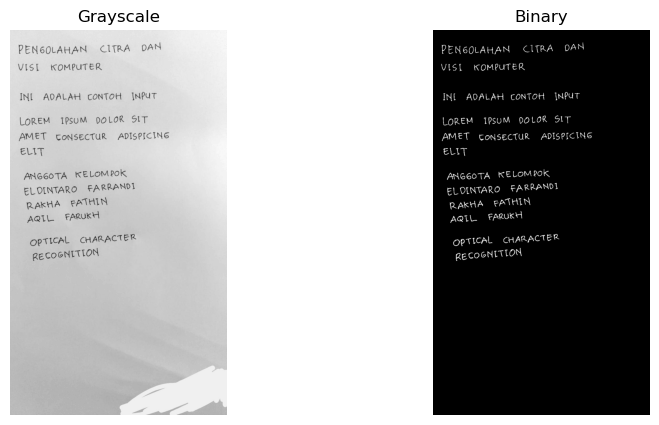

PENGOLAHAN CLTRA DAN
VLSL KOMPUTER
INI ADALAH CONTOH LNPUT
LOREM IPSUM DOLOR SIT
AMET CONSECTUR ADISPICING
ELIT
ANGGOTA KELOMKOK
ELDINTARO FARRANDI
RAKHA FAKHIN
AQIL FARUKH
OPTICAL CHARACTER
RECOGNITION



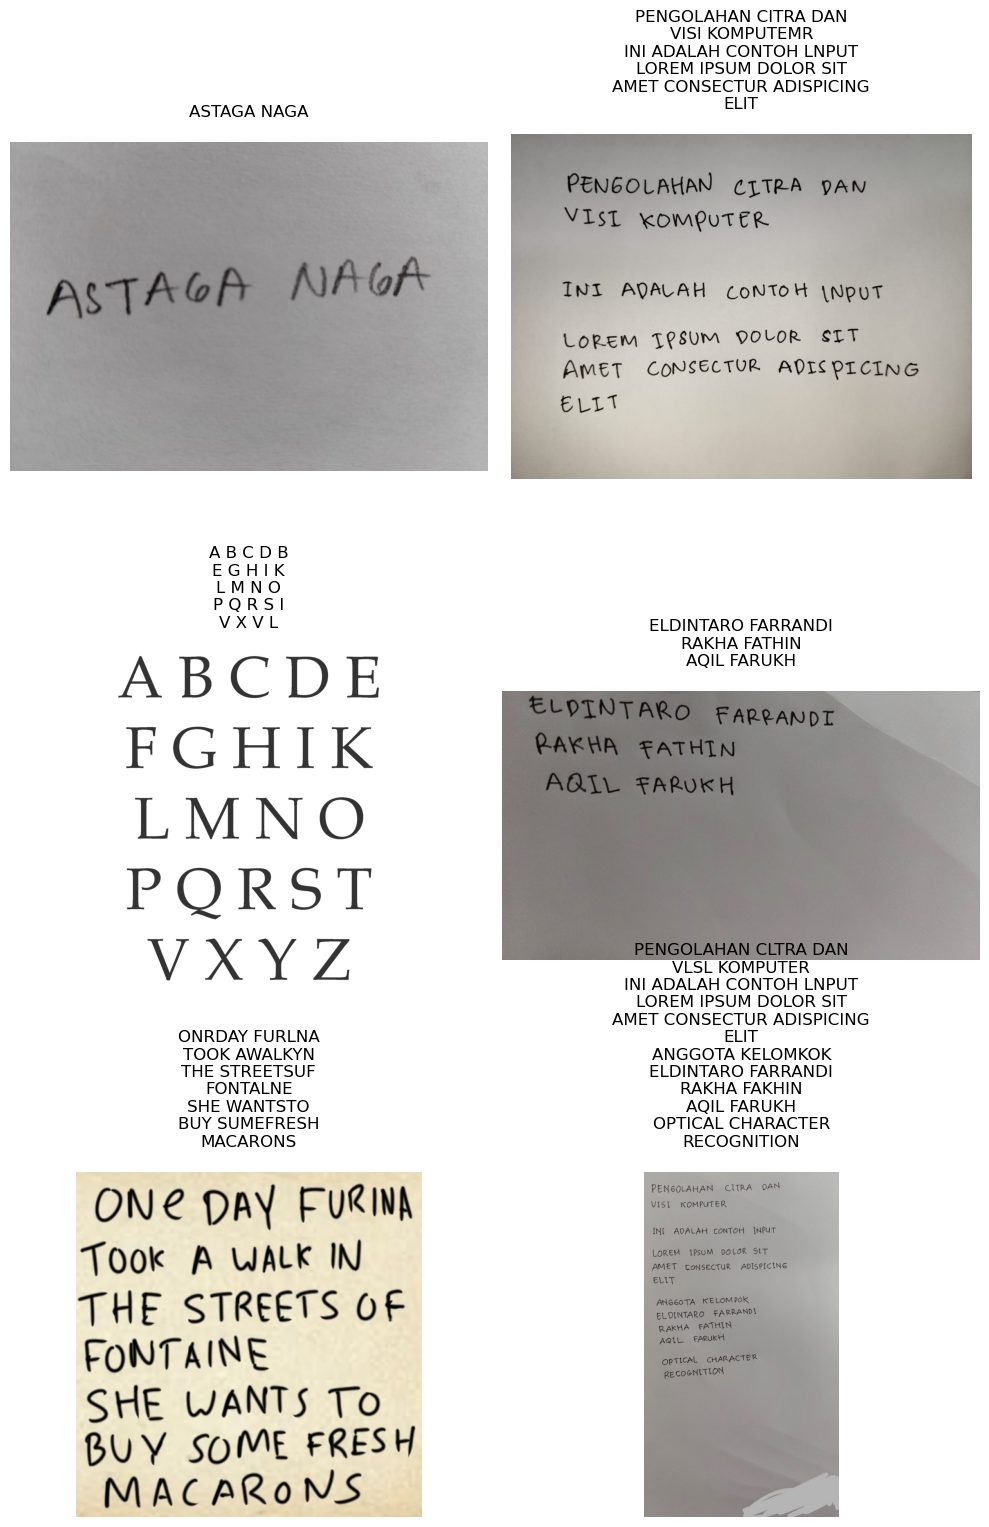

In [13]:
image_paths = [
    "image/Screenshot 2024-12-12 104859.png",
    "image/tulisan1.jpg",
    'image/tulisan2.jpg',
    "image/tulisan3.jpg",
    "image/tulisan4.png",
    "image/tulisan5.jpg",
]

results = []
images = []

for image_path in image_paths:
    ch = segment_characters(image_path)
    predictions = predict_folder(model, "chars")
    result = display_sorted_predictions(predictions)
    results.append(result)
    
    img = PILImage.open(image_path)
    images.append(img)

n_images = len(images)
n_cols = 2
n_rows = math.ceil(n_images / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))

axes = np.array(axes).flatten()  

for idx, ax in enumerate(axes):
    if idx < n_images:
        ax.imshow(images[idx])
        ax.axis('off')
        ax.set_title(f'{results[idx]}', fontsize=12)
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()